# **Implementing Linear Regression from Scratch**

In this notebook, I am implementing a linear regression model to predict the price of a home based on its square footage. The algorithm is implemented from scratch using synthetic data to demonstrate the underlying mechanics without relying on high-level machine learning libraries. The goal is to find the 'line of best fit' that minimizes the error between the predictions and the actual market data. By manually updating the model's parameters through Gradient Descent, we gain a deep understanding of how machines learn to recognize patterns and optimize predictions from raw data.

### Importing Necessary Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Generation & Preprocessing

Before we can train the model, we need data. This section defines a function to create a synthetic housing dataset that mimics real-world behaviour.


1. <b>The Generative Model:</b><br>
We use a linear equation with added Gaussian noise to simulate market volatility:
$$Price = (Price\ per\ Square\ Footage \times Total\ Square\ Footage) + Base \ Price + \epsilon$$
where $\epsilon$ (noise) represents factors other than size, such as location or age.


2. <b>Standardization (Z-score Normalization):</b><br>
Machine learning models, especially those using Gradient Descent, perform better when features are on a similar scale. Without scaling, the large values in Price (hundreds of thousands) would cause the gradients to explode, making the model impossible to train.
We transform the data using the formula:

    $$z = \frac{x - \mu}{\sigma}$$ where $x$: The original value, $\mu$: The mean of the data and $\sigma$: The standard deviation

3. <b>Function generate_housing_data:</b><br>
The function generate_housing_data returns three essential components:<br>**df_original**: The human-readable data (e.g., 2,500 sq ft, $550,000).<br>**df_scaled**: The version used for training (values centered around 0).<br>**scale_params**: A dictionary containing the original means and standard deviations. We need these later to de-scale the predictions back into actual dollar amounts.

In [10]:
def generate_housing_data(n_samples=100, seed=42):
    """
    Generates a synthetic house price dataset with Square Footage and Price.
    Returns: Original DataFrame, Scaled DataFrame, and Scaling Parameters.
    """
    np.random.seed(seed)

    # Generate Raw Data
    sq_ft = np.random.randint(500, 5001, size=n_samples).astype(float)
    price_per_sqft = 200
    base_price = 50000
    noise = np.random.normal(0, 70000, size=n_samples)

    prices = (price_per_sqft * sq_ft) + base_price + noise

    # Create DataFrame
    df = pd.DataFrame({
        'Square_Footage': sq_ft,
        'Price': np.round(prices, 2)
    })

    # Calculate Scaling Parameters (needed for later de-scaling)
    params = {
        'mean_x': df['Square_Footage'].mean(),
        'std_x': df['Square_Footage'].std(),
        'mean_y': df['Price'].mean(),
        'std_y': df['Price'].std()
    }

    # Create Scaled Version
    df_scaled = pd.DataFrame()
    df_scaled['X'] = (df['Square_Footage'] - params['mean_x']) / params['std_x']
    df_scaled['y'] = (df['Price'] - params['mean_y']) / params['std_y']

    return df, df_scaled, params

# Usage:
df_original, df_scaled, scale_params = generate_housing_data(n_samples=100)

print("--- Original Data ---")
print(df_original.head())
print("\n--- Scaled Data for Model ---")
print(df_scaled.head())

--- Original Data ---
   Square_Footage       Price
0          1360.0   278958.70
1          4272.0   927702.47
2          3592.0   671749.81
3           966.0   223543.56
4          4926.0  1031012.79

--- Scaled Data for Model ---
          X         y
0 -1.025967 -1.140253
1  1.254760  1.271655
2  0.722173  0.320071
3 -1.334554 -1.346276
4  1.766983  1.655743


**Scatter plot** showing square footage Vs the house price of the dataset

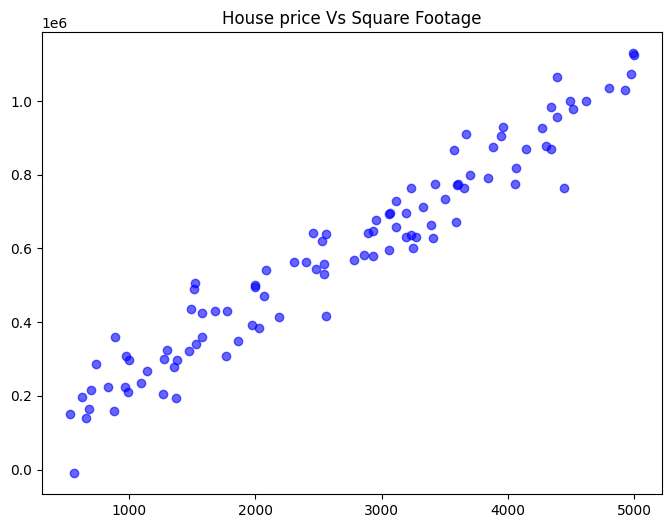

In [11]:
# Plot of the original Data
plt.figure(figsize=(8, 6))
plt.scatter(df_original['Square_Footage'], df_original['Price'], color='blue', alpha=0.6, label='Original Data')
plt.title("House price Vs Square Footage")
plt.show()

### Linear Regression Model with Gradient Descent

This function implements the "brain" of the model. Instead of using a library to find the best-fit line, we use Gradient Descent, an optimization algorithm that iteratively minimizes the prediction error.

1. Model Parameters:<br>We are trying to find the best values for two variables:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w$ (Weight): The slope of the line (how much the price changes per unit of square footage).<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$b$ (Bias): The y-intercept (the base price when square footage is zero).

2. The Cost Function:<br> Mean Squared Error (MSE)To know how "wrong" the model is, we calculate the MSE:
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{pred} - y_{actual})^2$$The goal of the training loop is to drive this value as close to zero as possible.

3. Gradient Descent (The Update Rule)<br>In each iteration (epoch), the function calculates the gradient (the slope of the error). This tells us which direction to move $w$ and $b$ to reduce the error.The parameters are updated using the Learning Rate ($\alpha$):
$$w = w - \alpha \cdot \frac{\partial MSE}{\partial w}$$
$$b = b - \alpha \cdot \frac{\partial MSE}{\partial b}$$

4. Key Logic in the Code Initialization:<br> We start with $w=0$ and $b=0$.<br>Vectorized Calculation: We use NumPy to calculate predictions for all the samples simultaneously, making the code much faster than using a standard Python for loop.<br>Cost History: We store the error at every step so we can later plot the "Learning Curve" to verify the model is actually converging.

In [12]:
def train_linear_regression(X, y, learning_rate=0.1, epochs=50):
    """
    Performs Gradient Descent to learn weights for Linear Regression.

    Returns:
    - w: final weight
    - b: final bias
    - cost_history: list of MSE values per epoch
    """
    n = len(y)
    # Initialize parameters
    w = 0.0
    b = 0.0
    cost_history = []

    # Training Loop
    for i in range(epochs):
        # Calculate prediction
        y_pred = w * X + b

        # Calculate Mean Squared Error
        mse = np.mean((y_pred - y)**2)
        cost_history.append(mse)

        # Calculate Gradients (Partial Derivatives)
        dw = (2/n) * np.sum(X * (y_pred - y))
        db = (2/n) * np.sum(y_pred - y)

        # Update parameters (Gradient Descent step)
        w -= learning_rate * dw
        b -= learning_rate * db

        # Print progress every 10% of total epochs
        if i % (epochs // 10) == 0:
            print(f"Epoch {i}: Cost {mse:.4f}")

    return w, b, cost_history


In [13]:
def plot_results(df, cost_history, w, b, params):
    """Generates two separate plots for data/fit and cost history."""

    # Plot 1: Raw Data and Best Fit Line
    plt.figure(figsize=(8, 6))
    plt.scatter(df['Square_Footage'], df['Price'], color='blue', alpha=0.6, label='Actual Data')

    # Mapping the scaled model back to original dimensions
    x_range = np.linspace(df['Square_Footage'].min(), df['Square_Footage'].max(), 100)
    x_range_scaled = (x_range - params['mean_x']) / params['std_x']
    y_pred_scaled = w * x_range_scaled + b
    y_pred_raw = (y_pred_scaled * params['std_y']) + params['mean_y']

    plt.plot(x_range, y_pred_raw, color='red', linewidth=3, label='Best Fit Line')
    plt.title('House Price Prediction: Square Footage vs Price')
    plt.xlabel('Square Footage')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('regression_fit.png') # Saved as an image

    # Plot 2: Cost Function reduction
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(cost_history)), cost_history, color='green', linewidth=2)
    plt.title('Cost Function (Mean Squared Error) Reduction')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('cost_history.png') # Saved as an image
    plt.show()

### Model Accuracy - R² Score

The $R^2$ Score, also known as the Coefficient of Determination, is a statistical measure that tells us how well the model's predictions approximate the real data points. An $R^2$ of 1.0 means the model perfectly predicts every value, while 0.0 means the model is no better than simply guessing the average price for every house.The $R^2$ Formula$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$Where:<br>$SS_{res}$ (Residual Sum of Squares): The sum of the squared differences between actual values and your predictions.<br>$SS_{tot}$ (Total Sum of Squares): The sum of the squared differences between actual values and the mean of the data.

In [14]:
def calculate_r2_score(y_true, y_pred):
    """
    Calculates the R^2 score to evaluate the model's accuracy.
    """
    # 1. Calculate the mean of the actual prices
    y_mean = np.mean(y_true)

    # 2. Calculate the Total Sum of Squares (SStot)
    ss_tot = np.sum((y_true - y_mean)**2)

    # 3. Calculate the Residual Sum of Squares (SSres)
    ss_res = np.sum((y_true - y_pred)**2)

    # 4. Final R2 calculation
    r2 = 1 - (ss_res / ss_tot)
    return r2


### Training the Model

Epoch 0: Cost 0.9900
Epoch 5: Cost 0.1626
Epoch 10: Cost 0.0716
Epoch 15: Cost 0.0615
Epoch 20: Cost 0.0604
Epoch 25: Cost 0.0603
Epoch 30: Cost 0.0603
Epoch 35: Cost 0.0603
Epoch 40: Cost 0.0603
Epoch 45: Cost 0.0603


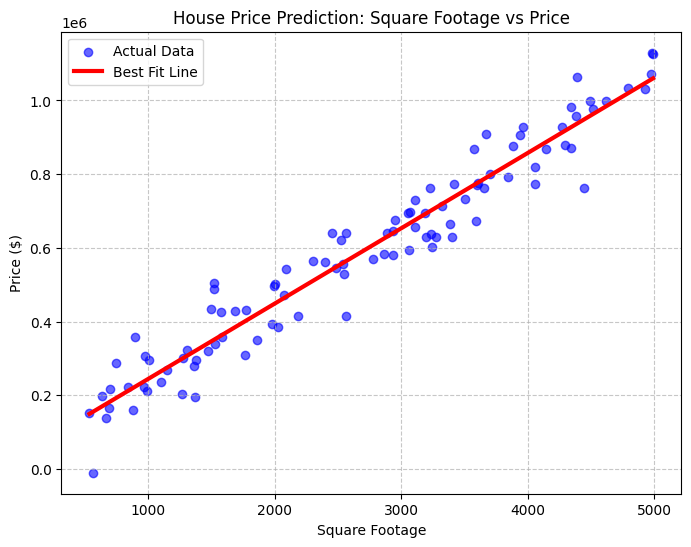

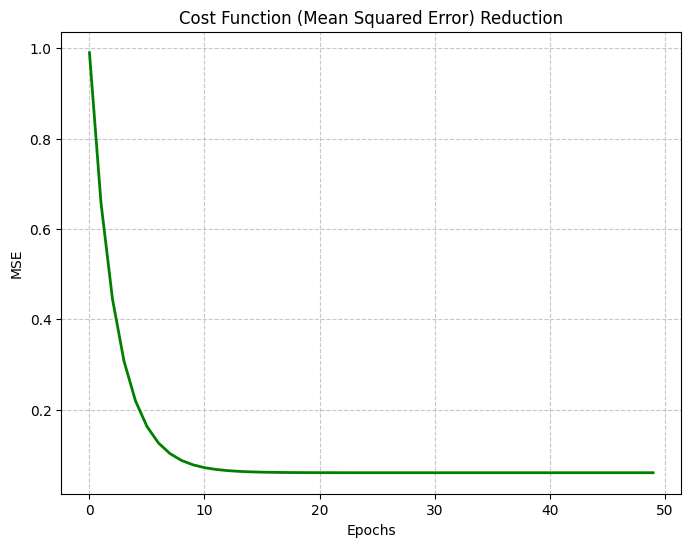

Model R^2 Score: 0.9391
Accuracy: 93.91%


In [15]:
# 1. Prepare data variables clearly
X_train = df_scaled['X'].values
y_train = df_scaled['y'].values

# 2. Train
w_final, b_final, costs = train_linear_regression(X_train, y_train)

# 3. Plot (Updated function to include plt.show())
plot_results(df_original, costs, w_final, b_final, scale_params)
plt.show()

# 4. Calculate R2 accurately
y_final_pred = w_final * X_train + b_final
score = calculate_r2_score(y_train, y_final_pred)

print(f"Model R^2 Score: {score:.4f}")
print(f"Accuracy: {score * 100:.2f}%")

### Model Prediction

The predict_price function implements the following

1. Pre-processing (Scaling)

2. Inference <br> Pass the scaled input through the linear equation:$$\hat{y}_{scaled} = w \cdot x_{scaled} + b$$

3. Post-processing (De-scaling) <br>The result is a scaled number (e.g., 0.45). To turn this back into a dollar amount, we perform the inverse of the standardization formula:$$Price = (\hat{y}_{scaled} \times \sigma_{price}) + \mu_{price}$$This ensures final output is a human-readable price that fits within the original dataset's range.

In [16]:
def predict_price(sq_ft_input, w, b, params):
    """
    Predicts the price for a given square footage.
    - sq_ft_input: The raw square footage (e.g., 2500)
    - w, b: Trained parameters
    - params: Dictionary containing original mean and std
    """
    # 1. Scale the input using training parameters
    x_scaled = (sq_ft_input - params['mean_x']) / params['std_x']

    # 2. Predict (scaled price)
    y_scaled_pred = w * x_scaled + b

    # 3. Reverse the scaling to get actual price in dollars
    final_price = (y_scaled_pred * params['std_y']) + params['mean_y']

    return np.round(final_price, 2)

# --- Example Usage ---
custom_sqft = 2500
estimated_price = predict_price(custom_sqft, w_final, b_final, scale_params)

print(f"House Size: {custom_sqft} sq ft")
print(f"Estimated Market Price: ${estimated_price:,}")

House Size: 2500 sq ft
Estimated Market Price: $550,965.72
